# Neural Networks

Artificial neural networks (ANNs) are everywhere in today's world where AI is dominating every field and almost any AI-related system is associated with some kind of ANN-based system. Their effective usage in practice with the collection of immense amounts of data and the recent advancements in computational technology made a breakthrough, thus understanding ANNs is crucial for any machine learning professional. They are usually considered as blackboxes where a vector data is given as input (this can be tabular data, media or text) and a number is spitted out, which is true but what is happening in between these input/outputs are also interesting. Many readily available AI tools and the existence of frameworks like PyTorch and Tensorflow also adds to the reality of this blackbox notion, where one can train a model easily without having a through grasp of the architecture achieving it. This notebook is aimed to break this understanding a little by starting from 'function approximation' and going to neural networks to be used for that purpose, because at the very heart of it, this is what they are. Neural networks are very sophisticated function approximators and their flexibility to be adapted on any function is the reason why they are so attractive nowadays.

## 1D Function Approximation Example

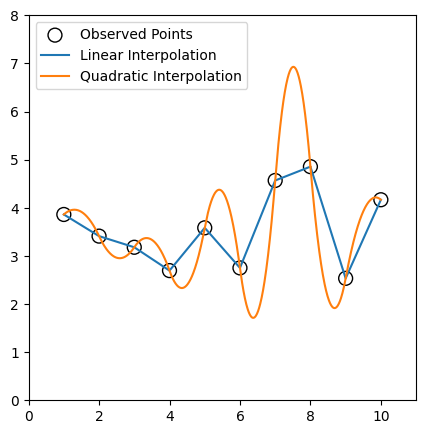

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def quadratic_interpolate(x_vals, y_vals, num_points=100):
    """
    Quadratic spline interpolation ensuring continuity in the first derivative.

    Parameters:
    x_vals (array): The x-coordinates of the given points.
    y_vals (array): The y-coordinates of the given points.
    num_points (int): Number of interpolation points between each pair of given points.

    Returns:
    x_interp (array): Interpolated x values.
    y_interp (array): Interpolated y values.
    """

    a_=[]; b_=[]; c_=[]
    for i in range(len(x_vals)-1):
        if i==0 or i==len(x_vals)-2: # endpoints with linear interpolation
            a_.append(0)
            b_.append((y_vals[i+1]-y_vals[i])/(x_vals[i+1]-x_vals[i]))
            c_.append(y_vals[i]-b_[i]*x_vals[i])
        else:
            x0, x1 = x_vals[i], x_vals[i+1]
            y0, y1 = y_vals[i], y_vals[i+1]

            # Enforce continuity of first derivative at x_i
            A = np.array([[x0**2, x0, 1],
                          [x1**2, x1, 1],
                          [2*x0, 1, 0]])
            b_vector = np.array([y0, y1, 2 * a_[-1] * x0 + b_[-1]])  # Previous segment's derivative

            coeffs = np.linalg.solve(A, b_vector)

            a_.append(coeffs[0])
            b_.append(coeffs[1])
            c_.append(coeffs[2])

    x_interp, y_interp = [], []

    for i in range(len(x_vals)-1):
        a, b, c = a_[i], b_[i], c_[i]
        x_fine = np.linspace(x_vals[i], x_vals[i+1], num_points)
        y_fine = a * x_fine**2 + b * x_fine + c
        x_interp.extend(x_fine)
        y_interp.extend(y_fine)

    return np.array(x_interp), np.array(y_interp)

# Generate random data
np.random.seed(0)
x_vals = np.linspace(1-1,10+1,12) # one extra point at the beginning and end to make quadratic interpolation look more smooth
y_vals = np.random.uniform(low=1.0, high=5.0, size=(12,1))

plt.figure(figsize=(5,5))
plt.scatter(x_vals[1:-1], y_vals[1:-1], s=100, facecolors='none', edgecolors='black', label='Observed Points')

#Linear interpolation
plt.plot(x_vals[1:-1], y_vals[1:-1], label='Linear Interpolation')

# Quadratic interpolation
num_points=100
x_interp, y_interp = quadratic_interpolate(x_vals, y_vals, num_points=num_points)
plt.plot(x_interp[num_points:-num_points], y_interp[num_points:-num_points], label='Quadratic Interpolation')

plt.xlim([0,11])
plt.ylim([0,8])
plt.legend()
plt.show()

Think about the case given in the above figure, where we have certain points obtained from an experiment. Most often, one wants to make generalizations based on the observations of an experiment so that if a similar situation arises, educated estimations can be done especially for the numerical values that were not directly observed in the experiment directly but it can be used as a nice tool for a guess. One approach can be extending the values observed for the gaps after them where there is no real observation. This case would have a stair-case like shape in the plot and although it gives a rough guess on the real value, the overall function will not be natural enough because real world has more continuous relationships between parameters. Moreover, if the intervals between the datapoints are not uniform as in the above plot, this may then to give larger errors for the unobserved parts. Hence, some interpolation technique is a better choice.

The most trivial method is a piecewise connection of the existing points with a straight line as shown with blue in the graph. This gives more resolution to the number of values that can be obtained and a better choice than the extension of existing values. Still the sharp transitions at the experiment points are generally undesired, in that case smoother options can be chosen. In the plot, a piecewise quadratic interpolation is given as example for that where each interval is connected with a 2nd order polynomial that passes from 2 consecutive points and also continuous in the 1st derivative. This is called spline interpolation and can be extended for higher order polynomials based on the application.

Basically what we have done above is that based on observation points we have, we tried to fit an appropriate function to make a better generalization of our case. The process can be tried with different methods. Instead of piecewise polynomials between two points, polynomials fitting to multiple points or the whole data can be selected, though the second approach generally ends up with bad generalization due to too much complexity. Other function types like logarithms, exponentials can also be suitable candidates. We can use prior information, like if we know this is a band limited signal, we can try to make our fit in the frequency domain. Generally we don't even have to find a fit that passes from all the points but rather find a function that is closest to all the points based on a certain metric. This is even preferrable in real world cases because real data is noisy and the points will always have minor errors from their true values. All of these are valid approaches to make function approximations and neural networks are one of the most advanced forms of it, that we will investigate more closely in the following sections.

## Cubic Activation Example

The previous section was a discussion on possible ways to approximate a function, given limited number of points from an actual realization of it. The alternatives, while limited, provided useful insights into function approximation and led to path to the functionality of neural networks. When there is an unknown function, most probably having no direct analytical form; the known functions can be adopted. Polynomials are in particular common candidates to achieve that because of their diffentiability to higher order which is a desired property most of the time. The given example was using piecewise versions of the known functions in certain intervals, one other approach can be using their superpositions to approximate the general function. With sufficient number of function versions to be used in superposition and assigning correct coefficients to each of them, a good approximation can be obtained.

At this point we can talk about **Universal Approximation Theorem** which is the basic reason of encouragement for usage of neural networks. It can be stated as "*A composition of two sets of linear transformations (matrix multiplications) with sufficiently large but finite number of coefficients with an arbitrary predetermined nonlinear function applied element-wise in between can approximate any continuous function on a compact domain to arbitrary accuracy.*". This means that 2 matrix multiplications connected with ANY nonlinear function in between them can imitate any function. The accuracy of the approximation will naturally increase if number of coefficients in linear transformations increase but it can at least be achieved within an error margin. The crucical point is then finding the optimum coefficents for the linear parts to make this approximation as close as possible. The theorem does not state how to find those coefficients. It only states that it is possible. Formulizing this if we have an unknown function $f(\mathbf{\text{x}})$ that we want to approximate, coefficient (or weight) matrices $W_1$ and $W_2$, a nonlinearity $\psi(\mathbf{\text{x}})$, we can have;

$$
f(\mathbf{\text{x}}) \cong W_2 \cdot \psi(W_1 \mathbf{\text{x}})
$$

And this is the simple notation of a neural network with exactly 1 hidden layer.

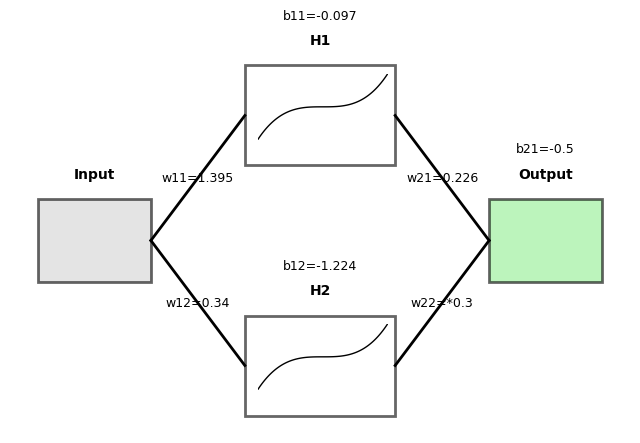

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Create figure and main axis
fig, ax = plt.subplots(figsize=(8, 5))
ax.axis("off")

# Function to draw larger rectangles for neurons (with biases displayed on top)
def draw_node(ax, x, y, text, text2=None, facecolor='white', width=2.0, height=1.2):
    rect = patches.Rectangle((x - width / 2, y - height / 2), width, height,
                             edgecolor='black', facecolor=facecolor, alpha=0.6, lw=2)
    ax.add_patch(rect)
    ax.text(x, y + height / 2 + 0.3, text, ha='center', va='center', fontsize=10, weight='bold')  # Neuron label
    # ax.text(x, y + height / 2 + 0.6, f"b={bias:.3f}", ha='center', va='center', fontsize=9, color='black')  # Bias on top
    if text2:
      ax.text(x, y + height / 2 + 0.6, text2, ha='center', va='center', fontsize=9, color='black')  # Bias on top

    return x, y, width, height  # Return these values for proper positioning

# Function to draw connections (weights displayed on lines)
def draw_line(ax, x1, y1, x2, y2, text):
    ax.plot([x1, x2], [y1, y2], 'k-', lw=2)
    mid_x, mid_y = (x1 + x2) / 2, (y1 + y2) / 2  # Midpoint for weight text
    ax.text(mid_x, mid_y, text, ha='center', va='center', fontsize=9, color='black')

# Define neuron positions
input_x, input_y = 0, 2.5  # Input neuron
hidden_x, hidden_y = 3, [4, 1]  # Hidden layer (2 neurons)
output_x, output_y = 6, 2.5  # Output neuron

# Draw neurons with biases on top
draw_node(ax, input_x, input_y, "Input", facecolor='lightgray', width=1.5, height=1.0)  # No bias in input
hidden_neurons = [
    draw_node(ax, hidden_x, hidden_y[0], "H1", text2="b11=-0.097", facecolor='white', width=2.0, height=1.2),
    draw_node(ax, hidden_x, hidden_y[1], "H2", text2="b12=-1.224", facecolor='white', width=2.0, height=1.2)
]
draw_node(ax, output_x, output_y, "Output", text2="b21=-0.5", facecolor='lightgreen', width=1.5, height=1.0)

# Draw connections (weights on lines)
draw_line(ax, input_x + 0.75, input_y, hidden_x - 1.0, hidden_y[0], text="w11=1.395")  # Input -> H1
draw_line(ax, input_x + 0.75, input_y, hidden_x - 1.0, hidden_y[1], text="w12=0.34")  # Input -> H2
draw_line(ax, hidden_x + 1.0, hidden_y[0], output_x - 0.75, output_y, text="w21=0.226")  # H1 -> Output
draw_line(ax, hidden_x + 1.0, hidden_y[1], output_x - 0.75, output_y, text="w22=*0.3")  # H2 -> Output

# Function to embed plots in hidden neurons
def plot_cubic(ax):
    x_vals = np.linspace(-1, 1, 100)
    y_vals = x_vals**3  # Cubic function
    ax.plot(x_vals, y_vals, color='black', lw=1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

# Add function plots **inside** the enlarged hidden neurons correctly
for (hx, hy, w, h) in hidden_neurons:
    inset = inset_axes(ax, width=w * 0.65, height=h * 0.55,  # Slightly reduce width/height
                   bbox_to_anchor=(hx - w / 2 + 0.1, hy - h / 2 + 0.1, w - 0.2, h - 0.2),
                   bbox_transform=ax.transData, borderpad=0)
    plot_cubic(inset)

# # Set title
# plt.title("Neural Network Visualization with Weights & Biases on Top")

# Show plot
plt.show()


Now let's realize this function approximation idea with a very simple neural network with only 1 hidden layer and this layer having 2 neurons, as shown in the above figure. As the nonlinearity, cubic function $x^3$ is used here to give a different example than the typical sigmoid or tanh functions. This system will be the exact implementation of the function;
$$
\hat{y}=f_{\text{NN}}(x)= w_{21}(w_{11}x+b_{11})^3+w_{22}(w_{12}x+b_{12})^3+b_{21}
$$

The function $f_{\text{NN}}$ with subscript ${\text{NN}}$ is used to distinguish it from the function to be approximated $f$.

Hence, basically we have two linear functions who are put in a cubic function and their cubed results are also linearly summed, as well. This is basically what every neural network outputs in reality. The main difference, of course, is that the scale where we have more weights in each stage and many more stages in real world applications.

Let's make a term by term derivation of how to make a training on this network to find the optimal weights for a given training set. It was mentioned that the universal approximation theorem states the above form can implement any function with varying accuracy but the theorem did not state how to find the optimal form for that (i.e. how to find the optimal weights $w_{ij}$ and biases $b_{ij}$). Backpropagation is an algorithm used to compute gradients efficiently in a neural network. The process begins with forward propagation, where input data passes through the network to produce an output $\hat{y}$. The error between the predicted output $\hat{y}$ and the ground truth $y$ is then computed. In deeper networks with more than 1 layer, this is done in a sequential manner from the final layer to the initial layer and hence the name "backpropagation". The gradients of each weight and bias of the error is computed and based on these gradients those parameters will be updated in a way that with each iteration the error will get smaller. Note that since the backpropagation relies on the gradients, which the nonlinearities gradients will be taken inevitably, it adds the further condition on the plausible nonlinearities that they must be at least piecewise differentiable. The cubic function in our example obeys this for the 1 hidden layer cases (note that gradients would be 0 if there were more than 4 layers).

A common error function used is the square error;

$$
E=(\hat{y}-y)^2 \\
$$

Here $\hat{y}$ are the outputs of the neural network which are called **predictions** and $y$ are the real values they must take which are called the **ground truths**. We need derivatives/gradients of this error w.r.t. weights $w_{ij}$ and biases $b_{ij}$, which let's gather them in a unified notation $\theta_{ij}$ for simplicity. As can be seen, the error does not directly depend on those parameters but the predictions $\hat{y}$, that appear in error function, are the direct results of $\theta_{ij}$. In that case the famous chain rule will be used to compute the overall derivative;

$$
\frac{\partial E}{\partial \theta_{ij}} = \frac{\partial E}{\partial \hat{y}} \frac{\partial \hat{y}}{\partial \theta_{ij}}
$$

Hence, we have a term $\frac{\partial E}{\partial \hat{y}}$ that appears for any parameter $\theta_{ij}$. Let's first calculate it as a common term as;

$$
\frac{\partial E}{\partial \hat{y}}=2(\hat{y}-y)
$$

Typically derivatives of the parameters $\frac{\partial \hat{y}}{\partial \theta_{ij}}$ are generally written as a sequential formula for each layer (a natural result of backpropagation) because this makes it more tractable as the number of layers increases. However, for this simple case where we have a closed form formula for $\hat{y}$, we can write each individual gradient directly;

$$
\frac{\partial \hat{y}}{\partial w_{11}}= 3w_{21}(w_{11}x+b_{11})^2x, \quad
\frac{\partial \hat{y}}{\partial w_{12}} = 3w_{22}(w_{12}x+b_{12})^2x \\
\frac{\partial \hat{y}}{\partial w_{21}}=(w_{11}x+b_{11})^3, \quad
\frac{\partial \hat{y}}{\partial w_{22}}=(w_{12}x+b_{12})^3 \\
\frac{\partial \hat{y}}{\partial b_{11}}= 3w_{21}(w_{11}x+b_{11})^2, \quad
\frac{\partial \hat{y}}{\partial b_{12}} = 3w_{22}(w_{12}x+b_{12})^2 \quad
\frac{\partial \hat{y}}{\partial b_{21}} = 1 \\
$$

So far, we have treated the parameters as static entities. However, when talking about the update rule, the notion of iteration number has to be added in order to distinguish between the parameter value in previous iteration and the current one. It will be shown as a superscript $(k)$ for the $k^{\text{th}}$ iteration. For an arbitrary parameter $\theta_{ij}$, the update will be;

$$
\theta_{ij}^{(k+1)} = \theta_{ij}^{(k)} - \alpha \frac{\partial E}{\partial \theta_{ij}^{(k)}}
= \theta_{ij}^{(k)} - \alpha \frac{\partial E}{\partial \hat{y}} \frac{\partial \hat{y}}{\partial \theta_{ij}^{(k)}}
$$

where $\alpha$ is the learning rate. This is a hyperparameter that should be selected carefully where a really small rate will cause really slow convergence, and a very high one can cause divergence. A proper middle ground must be found. The above update rule is the **gradient descent** where the parameter of interest is updated proportional to the error gradient but to the opposite side of it (hence the '-' sign in front). This is because we are trying to minimize the error and the minimum point will be reached by going opposite to the gradient while going with the gradient direction will increase the error. Combining all these, the individual update equations for each parameter are;

$$
w_{11}^{(k+1)}
= w_{11}^{(k)} - \alpha \cdot 2(\hat{y}-y) \cdot 3w_{21}^{(k)}(w_{11}^{(k)}x+b_{11}^{(k)})^2x, \quad
w_{12}^{(k+1)}
= w_{12}^{(k)} - \alpha \cdot 2(\hat{y}-y) \cdot 3w_{22}^{(k)}(w_{12}^{(k)}x+b_{12}^{(k)})^2x \\[10pt]
w_{21}^{(k+1)}
= w_{21}^{(k)} - \alpha \cdot 2(\hat{y}-y) \cdot (w_{11}^{(k)}x+b_{11}^{(k)})^3, \quad
w_{22}^{(k+1)}
= w_{22}^{(k)} - \alpha \cdot 2(\hat{y}-y) \cdot (w_{12}^{(k)}x+b_{12}^{(k)})^3 \\[10pt]
b_{11}^{(k+1)}
= b_{11}^{(k)} - \alpha \cdot 2(\hat{y}-y) \cdot 3w_{21}^{(k)}(w_{11}^{(k)}x+b_{11}^{(k)})^2, \quad
b_{12}^{(k+1)}
= b_{12}^{(k)} - \alpha \cdot 2(\hat{y}-y) \cdot 3w_{22}^{(k)}(w_{12}^{(k)}x+b_{12}^{(k)})^2 \\[10pt]
b_{21}^{(k+1)}
= b_{21}^{(k)} - \alpha \cdot 2(\hat{y}-y)  \\
$$

Below is an example of how training our simple neural network works. The equations in the code can be simplified by using matrix operations more efficiently and built in deep learning frameworks like PyTorch. However, since this is a demonstration and the networks at hand is a simple one with only 7 parameters inn total (4 weights and 3 biases), everything is given individually within the code. Just keep in mind that simplifications are possible.

One crucial detail that comes even in this simple case is that the initialization of weights. There are certain initialization techniques like Xavier or He initialization which I will not go into here. However, the minimal thing that must be done is that the initilization must include some randomness to break the symmetry. The flexibility of the neural networks for approximation depends on the effective usage of the weights so that they should be able to take any value. Since for a given layer the network architecture is symmetric, if we also initialize the weights with same values, even after many iterations they will remain same for the same layer. This would be equivalent to using a neural network with only single connection and is not useful.

Epoch: 1/7000, MSE is 0.02365721327157419
Epoch: 501/7000, MSE is 0.011059178758302248
Epoch: 1001/7000, MSE is 0.011051130833975882
Epoch: 1501/7000, MSE is 0.011039973453715539
Epoch: 2001/7000, MSE is 0.011015435951855407
Epoch: 2501/7000, MSE is 0.010930544641223994
Epoch: 3001/7000, MSE is 0.01027163171127035
Epoch: 3501/7000, MSE is 0.009051945668821183
Epoch: 4001/7000, MSE is 0.008874801999098523
Epoch: 4501/7000, MSE is 0.008771388483538096
Epoch: 5001/7000, MSE is 0.008627810957656325
Epoch: 5501/7000, MSE is 0.008010536017822681
Epoch: 6001/7000, MSE is 0.0017486165186524425
Epoch: 6501/7000, MSE is 6.675204047442689e-07


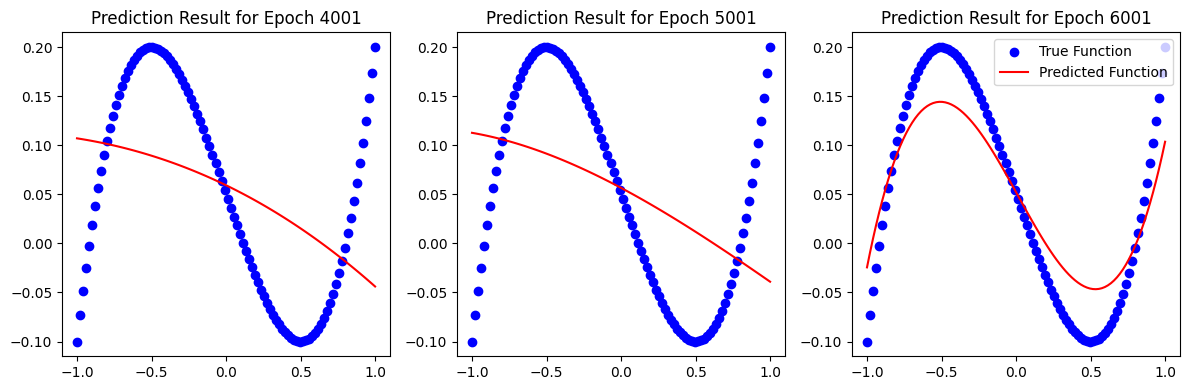

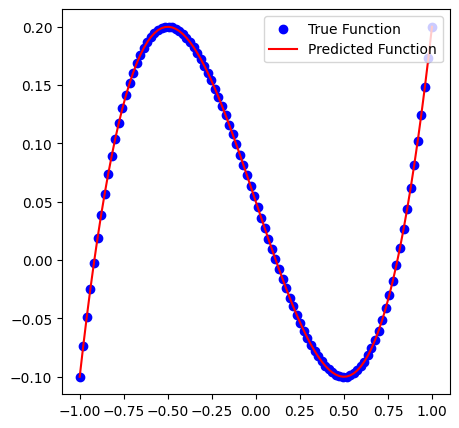

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def apply_nonlinear(x):
    return x**3

def feedforward(x, params):

    w11, w12, w21, w22, b11, b12, b21=params
    y=np.zeros(x.shape)
    for i in range(len(x)):
        y11=apply_nonlinear(w11*x[i]+b11)
        y12=apply_nonlinear(w12*x[i]+b12)

        y1 = w21*y11 + w22*y12 + b21
        y[i]=y1

    return y

x_train=np.linspace(-1,1,100)
y_train=0.6*x_train**3-0.45*x_train+0.05

np.random.seed(0)  # For reproducibility

w11, w12, b11, b12 = np.random.uniform(-0.5, 0.5, 4)
w21, w22, b21 = np.random.uniform(-0.5, 0.5, 3)

alpha = 0.1

num_epochs=7000
preds={}
for i in range(num_epochs):

    y_pred=feedforward(x_train, [w11, w12, w21, w22, b11, b12, b21])
    if i in [4000,5000,6000]:
        preds[i]=y_pred


    if i%500==0:
      print(f"Epoch: {i+1}/{num_epochs}, MSE is {np.mean((y_train-y_pred)**2)}")

    w11_old=w11; w12_old=w12; b11_old=b11; b12_old=b12
    w21_old=w21; w22_old=w22; b21_old=b21

    grad_w11 = np.mean(2*(y_pred-y_train)*3*w21_old*(w11_old*x_train+b11_old)**2*x_train)
    grad_w12 = np.mean(2*(y_pred-y_train)*3*w22_old*(w12_old*x_train+b12_old)**2*x_train)
    grad_w21 = np.mean(2*(y_pred-y_train)*(w11_old*x_train+b11_old)**3)
    grad_w22 = np.mean(2*(y_pred-y_train)*(w12_old*x_train+b12_old)**3)
    grad_b11 = np.mean(2*(y_pred-y_train)*3*w21_old*(w11_old*x_train+b11_old)**2)
    grad_b12 = np.mean(2*(y_pred-y_train)*3*w22_old*(w12_old*x_train+b12_old)**2)
    grad_b21 = np.mean(2*(y_pred-y_train))

    w11 -= alpha*grad_w11
    w12 -= alpha*grad_w12
    w21 -= alpha*grad_w21
    w22 -= alpha*grad_w22
    b11 -= alpha*grad_b11
    b12 -= alpha*grad_b12
    b21 -= alpha*grad_b21

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, [key, val] in enumerate(preds.items()):
    axes[i].scatter(x_train, y_train, label="True Function", color="blue")
    axes[i].plot(x_train, val, label="Predicted Function", color="red")
    axes[i].set_title(f"Prediction Result for Epoch {key+1}")

plt.legend()
plt.tight_layout()
plt.show()

# Final predictions
y_pred_final = feedforward(x_train, [w11, w12, w21, w22, b11, b12, b21])

# Plot results
plt.figure(figsize=(5,5))
plt.scatter(x_train, y_train, label="True Function", color="blue")
plt.plot(x_train, y_pred_final, label="Predicted Function", color="red")
plt.legend()
plt.show()


# w11=1.395; w12=0.34; b11=-0.097; b12=-1.224
# w21=0.226; w22=-0.3; b21=-0.5

## Backpropagation in More Detail

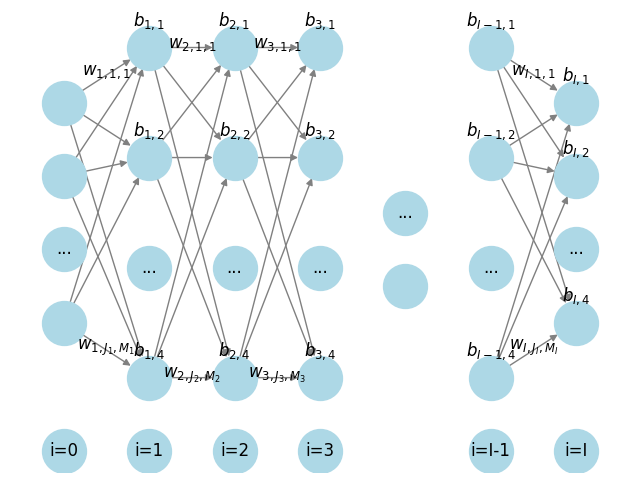

In [17]:
import matplotlib.pyplot as plt
import networkx as nx

def draw_neural_network():
    fig, ax = plt.subplots(figsize=(8, 6))
    G = nx.DiGraph()

    # Define layers
    layers = {
        'Input': [0, 1, "...", 4],
        'Hidden 1': [0, 1, "...", 4],
        'Hidden 2': [0, 1, "...", 4],
        'Hidden 3': [0, 1, "...", 4],
        'More Layers': ["..."],
        'Hidden n-1': [0, 1, "...", 4],
        'Output': [0, 1, "...", 4]
    }

    layer_indices = ['i=0', 'i=1', 'i=2', 'i=3', ' ', 'i=I-1', 'i=I']

    positions = {}
    y_spacing = 1.5
    x_spacing = 2
    layer_x = 0

    for idx, (layer_name, neurons) in enumerate(layers.items()):
        for i, neuron in enumerate(neurons):
            y_pos = -(i * y_spacing - (len(neurons) * y_spacing / 2))  # Flip direction (top to bottom)
            if layer_name in ['Input', 'Output']:
                y_pos = 2/3*y_pos + 0.25
            if neuron=='...':
                G.add_node(f'{layer_name}_{neuron}', pos=(layer_x, y_pos), label=str(neuron))
            else:
                G.add_node(f'{layer_name}_{neuron}', pos=(layer_x, y_pos))

            # Add small text over neurons except for input layer and "..."
            if neuron != "..." and ("Hidden" in layer_name or "Output" in layer_name):
                if idx == 5:
                    text_label = f'$b_{{I-1,{i+1}}}$'
                elif idx == 6:
                    text_label = f'$b_{{I,{i+1}}}$'
                else:
                    text_label = f'$b_{{{idx},{i+1}}}$'
                ax.text(layer_x, y_pos + 0.3, text_label, fontsize=12, ha='center')

            G.add_node(f'{layer_name}_{neuron}', pos=(layer_x, y_pos))

        # Add index label below each layer
        y_index_label = -((len(neurons) * y_spacing / 2) - 0.5)  # Position below the layer
        G.add_node(f'Index_{idx}', pos=(layer_x, y_index_label), label=layer_indices[idx])
        layer_x += x_spacing

    # Draw graph first to get node positions
    pos = nx.get_node_attributes(G, 'pos')

    # Connect layers and add selective weight labels
    layer_keys = list(layers.keys())
    for i in range(len(layer_keys) - 1):
        current_layer = layers[layer_keys[i]]
        next_layer = layers[layer_keys[i + 1]]

        first_neuron = current_layer[0] if current_layer[0] != "..." else None
        last_neuron = current_layer[-1] if current_layer[-1] != "..." else None
        first_next_neuron = next_layer[0] if next_layer[0] != "..." else None
        last_next_neuron = next_layer[-1] if next_layer[-1] != "..." else None

        for neuron in current_layer:
            for next_neuron in next_layer:
                if neuron != "..." and next_neuron != "...":
                    G.add_edge(f'{layer_keys[i]}_{neuron}', f'{layer_keys[i+1]}_{next_neuron}')

                    # Add weight label for selected connections
                    if (neuron == first_neuron and next_neuron == first_next_neuron) or \
                       (neuron == last_neuron and next_neuron == last_next_neuron):
                        if i == 4:
                            weight_label = f'$w_{{I-1,1,1}}$' if neuron == first_neuron else f'$w_{{I-1,J_{{I-1}},M_{{I-1}}}}$'
                        elif i == 5:
                            weight_label = f'$w_{{I,1,1}}$' if neuron == first_neuron else f'$w_{{I,J_{{I}},M_{{I}}}}$'
                        else:
                            weight_label = f'$w_{{{i+1},1,1}}$' if neuron == first_neuron else f'$w_{{{i+1},J_{{{i+1}}},M_{{{i+1}}}}}$'

                        # print(f"pos is {pos}")
                        node_pos1 = pos[f'{layer_keys[i]}_{neuron}']
                        node_pos2 = pos[f'{layer_keys[i+1]}_{next_neuron}']
                        mid_x = (node_pos1[0] + node_pos2[0]) / 2
                        mid_y = (node_pos1[1] + node_pos2[1]) / 2
                        ax.text(mid_x, mid_y, weight_label, fontsize=12, ha='center', color='black')

    # Draw graph
    pos = nx.get_node_attributes(G, 'pos')
    labels = nx.get_node_attributes(G, 'label')
    nx.draw(G, pos, with_labels=True, labels=labels, node_size=1000, node_color='lightblue', edge_color='gray')
    # plt.title("Vanilla Neural Network Structure")
    plt.show()

draw_neural_network()

Now let's go through the further discussion of the backpropagation. As we said, the mechanism of gradient descent works by updating the parameters based on their derivative w.r.t. error function obtained in the forward pass. Thus, the crucial point is calculating this gradient. That was simple in our toy example where we had only 1 hidden layer and few neurons but in real networks as they get deeper, it can be computationally expensive and even infeasible to do these calculations for the initial layers. The reason is the error derivative w.r.t. parameters of initial layers depend on all the parameters between the layer of interest and output layer, and doing these calculations repeatedly is not practical. The nice thing is once the error derivatives of the next layers are calculated, they can be used in the calculation of the derivative of the current layer in a recursive manner, and it will remove the intensity of doing the same calculations all over.

For the discussion here assume we have a network as above with $I$ layers in total. Each layer is indexed with letter $i$, and each layer contains $M_i$ number of neurons. Here all the parameters will have the layer index $i$. Other than that the weights will have 3 indices in total as $w_{i,j,m}$, the extra indices ${j,m}$ encoding the neuron number of previous and current layers respectively. Biases will be denoted as $b_{i,m}$ with only 2 indexes becuase they are only relevant for the neuron of a given layer and not the previous one.

Let's define further variables. The activations, i.e. the outputs of the nonlinear actions will be denoted with $a_{i,m}$ and the linear combination of previous layer activations with weights will be denoted as $z_{i,m}$. These two can be formulized as below where $\sigma$ shows an arbitrary differentiable nonlinearity here.

$$
z_{i,m} = \sum_{j=1}^{J_{i-1}} a_{i-1,j} \, w_{i,j,m} + b_{i,m}, \quad a_{i,m}=\sigma\left( z_{i,m} \right)
$$

In order to apply gradient descent, we need the gradients w.r.t. weights and biases as below;

$$
\frac{\partial E}{\partial w_{i,j,m}} = \frac{\partial E}{\partial a_{i,m}} \frac{\partial a_{i,m}}{\partial w_{i,j,m}} \,\, , \quad
\frac{\partial E}{\partial b_{i,m}} = \frac{\partial E}{\partial a_{i,m}} \frac{\partial a_{i,m}}{\partial b_{i,m}}
$$

Here the second terms in the producut, i.e. derivatives of activations w.r.t. parameters can be easily found as;

$$
\frac{\partial a_{i,m}}{\partial w_{i,j,m}} = \frac{\partial a_{i,m}}{\partial z_{i,m}} \frac{\partial z_{i,m}}{\partial w_{i,j,m}} = \sigma^\prime(z_{i,m}) \, a_{i-1,j} \,\, , \quad
\frac{\partial a_{i,m}}{\partial b_{i,m}} = \frac{\partial a_{i,m}}{\partial z_{i,m}} \frac{\partial z_{i,m}}{\partial b_{i,m}} = \sigma^\prime(z_{i,m})
$$

Thus, the required information is the derivatives of activations $\sigma^\prime$ and the activations from previous layer. These are both available once the forward pass is done as long as we have a closed or approximate form of the nonlinearity derivative (which is generally chosen obeying this condition). The backpropagation is not required to compute these terms which are already known. but instead it is necessary in order to evaluate the error derivative term which is common to both equations. Note that it is still theoretically possible to compute these error derivatives by referring to the closed form formula of predictions as we did in the toy example at the beginning but it will not be practical for deep networks.

At this point, we need some intuition to find the derivatives of $E$ w.r.t. activations $a_{i,m}$. These activations effect the predictions $\hat{y}_m$ and in turn the error $E$ by their influence on the next layer activations $a_{i+1,m^\prime}$. Thus, we can write using a multivariable chain rule;

$$
\frac{\partial E}{\partial a_{i,m}} = \sum_{m^\prime=1}^{M_{i+1}} \frac{\partial E}{\partial a_{i+1,m^\prime}} \frac{\partial a_{i+1,m^\prime}}{\partial a_{i,m}}
$$

The second term is equal to;

$$
\frac{\partial a_{i+1,m^\prime}}{\partial a_{i,m}} = \frac{\partial a_{i+1,m^\prime}}{\partial z_{i+1,m^\prime}} \frac{\partial z_{i+1,m^\prime}}{\partial a_{i,m}} = \sigma^\prime(z_{i+1,m^\prime}) w_{i+1,m,m^\prime}
$$

And since in backpropagation, we propagate from the final layer to previous ones, while calculating error derivative for the $i^{\text{th}}$ layer, the $(i+1)^{\text{th}}$ layer derivatives are already calculated. Thus, instead of going through all the steps to the final layer to calculate this, we only need the derivative terms from the next layer which reduces the computations significantly.

Merging all of these, the final gradient formulas can be rewritten as;

$$
\frac{\partial E}{\partial w_{i,j,m}} = \sigma^\prime(z_{i,m}) \, a_{i-1,j} \sum_{m^\prime=1}^{M_{i+1}} \frac{\partial E}{\partial a_{i+1,m^\prime}} \sigma^\prime(z_{i+1,m^\prime}) w_{i+1,m,m^\prime} \\
\frac{\partial E}{\partial b_{i,m}} = \sigma^\prime(z_{i,m}) \sum_{m^\prime=1}^{M_{i+1}} \frac{\partial E}{\partial a_{i+1,m^\prime}} \sigma^\prime(z_{i+1,m^\prime}) w_{i+1,m,m^\prime}
$$



<!-- $$
\hat{y}_m = a_{I,m}=\sigma\left( \underbrace{\sum_{j=1}^{J_{I-1}} a_{I-1,j} w_{I,j,m} + b_{I,m}}_{=z_{I,m}} \right)=\sigma\left( z_{I,m} \right)
$$

$$
E=\sum_{m=1}^{m_I} (\hat{y}_m -y_m )^2
$$

$$
\frac{\partial E}{\partial w_{I,j,m}} = \frac{\partial E}{\partial \hat{y}_m} \frac{\partial \hat{y}_m}{\partial w_{I,j,m}}
=\frac{\partial E}{\partial \hat{y}_m} \frac{\partial \sigma\left( z_{I,m} \right)}{\partial z_{I,m}} \frac{\partial z_{I,m}}{\partial w_{I,j,m}} = 2(\hat{y}_m -y_m ) \,\sigma^\prime \left( z_{I,m} \right) \, a_{I-1,j} \\[10pt]
\frac{\partial E}{\partial b_{I,m}} = \frac{\partial E}{\partial \hat{y}_m} \frac{\partial \hat{y}_m}{\partial b_{I,m}}
=\frac{\partial E}{\partial \hat{y}_m} \frac{\partial \sigma\left( z_{I,m} \right)}{\partial z_{I,m}} \frac{\partial z_{I,m}}{\partial b_{I,m}} = 2(\hat{y}_m -y_m ) \,\sigma^\prime \left( z_{I,m} \right)
$$ -->

## Adam Optimizer

Adam (**ada**ptive **m**omentum) is an optimization technique that is widely used with neural networks. If no further problem-specific optimization algorithm is used, Adam is generally seen as the default. The technique is used to make the convergence faster by changing the learning rates adaptively for each parameter. Using a parameter-specific learning strategy is almost obligatory with structures like neural networks including many parameters, that can easily reach the order of billions in the case of current day large language models. The adaptation is done in two ways:

* **Parameter based:** Each parameter in a neural network has a different effect on the overall cost, thus each should be tuned accordingly. Although not a must, a general rule of thumb in neural networks is that initial layers need smaller learning rates while the end layers can tolerate or need higher ones. The reason is that initial layers tend to learn general abstract features so coarse tuning is better in their cases while the final layers generally learn task-specific features and fine tuning is necessary.

* **Iteration based:** At each iteration/epoch of a neural network training parameters remain in different parts of the loss landscape. In initial stages, most parameters have values that are much far from the optimum points so higher steps can help faster convergence here while as the iterations go forward, smaller learning rates become necessary.

Adam achieves its optimization performance based on 2 mechanisms: Momentum estimation and RMSProp algorithm. Both will be explained briefly. The notation used will be $\theta$ depicting a single parameter for the sake of simplicity. Just keep in mind that it denotes weights and biases as in the previous section.

### **Momentum**

Momentum is a mechanism to accelerate the covnergence speed of the training. Instead of just updating the parameter based on the current gradient $G ^{k+1}$, the gradients from previous iteration are accumulated with a factor of $\beta$. This way if the path taken in the loss function is in a certain direction for a few iterations, it means it is almost guaranteed to be in the next one so the speed is a little enhanced in that particular direction. The update formula with momentum is as follows;

$$
m^{(k+1)} = \beta_1 m^{(k)} + \eta G ^{(k+1)}\\
\theta^{(k+1)} = \theta^{(k)} - m^{(k+1)}
$$

### **RMSProp**

RMSProp is a technique to adapt the learning rate based on the current gradients. It takes a moving average of the squared gradients and each time divide the otherwise constant learning rate $\eta$ by the square root of it. This way even if the gradients themselves get too small by the scaling of the learning rate the updates will be in a more significant scale. The formula for RMSProp is given below.

$$
v^{(k+1)}= \beta_2 v^{(k)} + (1-\beta_2) \left[G^{(k+1)}\right]^2 \\
\theta^{(k+1)} = \theta^{(k)} - \frac{\eta}{\sqrt{v^{(k)}+\epsilon}} G^{(k+1)}\\
$$

Here $\epsilon$ is a small positive parameter to prevent division by zero.


### **Adam**

Adam is basically mergin of these 2 mechanisms in order to benefit from both of them. Instead of current gradient the accumulated ones are used in the update equation as in momentum case; and those updates are done proportional to a rescaled learning rate as in RMSProp. One addition of the Adam on top of merging these mechanisms is that, a warmup mechanism is applied so both accumulated gradients $m^{k+1}$ and accumulated squared gradients $v^{k+1}$ are rescaled in a manner that they will get lower values as iterations go forward. These rescaled versions are shown with $\hat{m}^{k+1}$ and $\hat{v}^{k+1}$. Combining all these ideas, the final algorithm is;

$$
m^{(k+1)} = \beta_1 m^{(k)} + (1 - \beta_1) G ^{(k+1)}, \quad
v^{(k+1)} = \beta_2 v^{(k)} + (1 - \beta_2) \left[G^{(k+1)}\right]^2 \\
\hat{m}^{(k+1)} = \frac{{m}^{(k+1)}}{1 - \beta_1^{k+1}} , \quad
\hat{v}^{(k+1)} = \frac{{v}^{(k+1)}}{1 - \beta_2^{k+1}} \\
\theta^{(k+1)} = \theta^{(k)} - \frac{\alpha \hat{m}^{(k+1)}}{\sqrt{\hat{v}^{(k+1)} + \epsilon}}
$$

Note that the superscript $k+1$'s are not written in parantheses for rescaling of $m^{(k+1)}$ and $v^{(k+1)}$ because they denote powers instead of iteration numbers. $\beta_1$ and $\beta_2$ are generally chosen strictly to be less than 1. Thus, with increasing power term the denominators have larger values, which makes overall scaled values smaller as the iterations progress.

Below is the implementation of the introduced Adam optimization. The selection of parameters $\beta_1=0.9$ and $\beta_2=0.999$ are the values in the original paper of Adam optimizer. Interested readers can reach it from [here](https://arxiv.org/abs/1412.6980).

Epoch 0, MSE: 0.023650906751082564
Epoch 100, MSE: 2.0565008819252846e-07


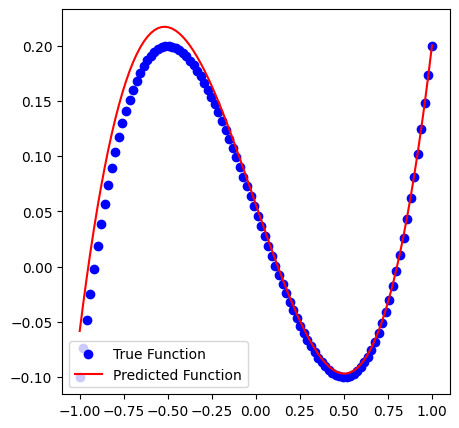

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Activation function
def apply_nonlinear(x):
    return x**3

# Feedforward function
def feedforward(x, params):
    w11, w12, w21, w22, b11, b12, b21 = params
    y = np.zeros(x.shape)
    for i in range(len(x)):
        y11 = apply_nonlinear(w11 * x[i] + b11)
        y12 = apply_nonlinear(w12 * x[i] + b12)
        y1 = w21 * y11 + w22 * y12 + b21
        y[i] = y1
    return y

# Generate dataset
x_train = np.linspace(-1, 1, 100)
y_train = 0.6 * x_train**3 - 0.45 * x_train + 0.05

# Initialize weights and biases
np.random.seed(0)  # For reproducibility
w11, w12, w21, w22 = np.random.uniform(-0.5, 0.5, 4)
b11, b12, b21 = np.random.uniform(-0.5, 0.5, 3)

# Adam hyperparameters
alpha = 0.1  # Learning rate
beta1 = 0.9  # Exponential decay rate for first moment
beta2 = 0.999  # Exponential decay rate for second moment
epsilon = 1e-8  # Avoid division by zero

# Initialize Adam moment estimates
m_w11, m_w12, m_b11, m_b12 = 0, 0, 0, 0
m_w21, m_w22, m_b21 = 0, 0, 0
v_w11, v_w12, v_b11, v_b12 = 0, 0, 0, 0
v_w21, v_w22, v_b21 = 0, 0, 0
t = 0  # Time step

# Training loop
# num_epochs = 1000
num_epochs = 200
for i in range(num_epochs):
    t += 1

    # Forward pass
    y_pred = feedforward(x_train, [w11, w12, w21, w22, b11, b12, b21])
    mse = np.mean((y_train - y_pred) ** 2)

    # Compute gradients
    grad_w11 = np.mean(2 * (y_pred - y_train) * 3 * w21 * (w11 * x_train + b11) ** 2 * x_train)
    grad_w12 = np.mean(2 * (y_pred - y_train) * 3 * w22 * (w12 * x_train + b12) ** 2 * x_train)
    grad_w21 = np.mean(2 * (y_pred - y_train) * (w11 * x_train + b11) ** 3)
    grad_w22 = np.mean(2 * (y_pred - y_train) * (w12 * x_train + b12) ** 3)
    grad_b11 = np.mean(2 * (y_pred - y_train) * 3 * w21 * (w11 * x_train + b11) ** 2)
    grad_b12 = np.mean(2 * (y_pred - y_train) * 3 * w22 * (w12 * x_train + b12) ** 2)
    grad_b21 = np.mean(2 * (y_pred - y_train))

    # Update moment estimates
    m_w11 = beta1 * m_w11 + (1 - beta1) * grad_w11
    m_w12 = beta1 * m_w12 + (1 - beta1) * grad_w12
    m_w21 = beta1 * m_w21 + (1 - beta1) * grad_w21
    m_w22 = beta1 * m_w22 + (1 - beta1) * grad_w22
    m_b11 = beta1 * m_b11 + (1 - beta1) * grad_b11
    m_b12 = beta1 * m_b12 + (1 - beta1) * grad_b12
    m_b21 = beta1 * m_b21 + (1 - beta1) * grad_b21

    v_w11 = beta2 * v_w11 + (1 - beta2) * grad_w11**2
    v_w12 = beta2 * v_w12 + (1 - beta2) * grad_w12**2
    v_w21 = beta2 * v_w21 + (1 - beta2) * grad_w21**2
    v_w22 = beta2 * v_w22 + (1 - beta2) * grad_w22**2
    v_b11 = beta2 * v_b11 + (1 - beta2) * grad_b11**2
    v_b12 = beta2 * v_b12 + (1 - beta2) * grad_b12**2
    v_b21 = beta2 * v_b21 + (1 - beta2) * grad_b21**2

    # Bias correction
    m_w11_hat = m_w11 / (1 - beta1**t)
    m_w12_hat = m_w12 / (1 - beta1**t)
    m_w21_hat = m_w21 / (1 - beta1**t)
    m_w22_hat = m_w22 / (1 - beta1**t)
    m_b11_hat = m_b11 / (1 - beta1**t)
    m_b12_hat = m_b12 / (1 - beta1**t)
    m_b21_hat = m_b21 / (1 - beta1**t)

    v_w11_hat = v_w11 / (1 - beta2**t)
    v_w12_hat = v_w12 / (1 - beta2**t)
    v_w21_hat = v_w21 / (1 - beta2**t)
    v_w22_hat = v_w22 / (1 - beta2**t)
    v_b11_hat = v_b11 / (1 - beta2**t)
    v_b12_hat = v_b12 / (1 - beta2**t)
    v_b21_hat = v_b21 / (1 - beta2**t)

    # Parameter updates
    w11 -= alpha * m_w11_hat / (np.sqrt(v_w11_hat) + epsilon)
    w12 -= alpha * m_w12_hat / (np.sqrt(v_w12_hat) + epsilon)
    w21 -= alpha * m_w21_hat / (np.sqrt(v_w21_hat) + epsilon)
    w22 -= alpha * m_w22_hat / (np.sqrt(v_w22_hat) + epsilon)
    b11 -= alpha * m_b11_hat / (np.sqrt(v_b11_hat) + epsilon)
    b12 -= alpha * m_b12_hat / (np.sqrt(v_b12_hat) + epsilon)
    b21 -= alpha * m_b21_hat / (np.sqrt(v_b21_hat) + epsilon)

    if i % 100 == 0:
        print(f"Epoch {i}, MSE: {mse}")

# Final predictions
y_pred_final = feedforward(x_train, [w11, w12, w21, w22, b11, b12, b21])

# Plot results
plt.figure(figsize=(5,5))
plt.scatter(x_train, y_train, label="True Function", color="blue")
plt.plot(x_train, y_pred_final, label="Predicted Function", color="red")
plt.legend()
plt.show()

We can directly see the strength of the Adam optimization looking at this training result. In order to have a proper approximation with direct gradient descent, we had to wait for 6000 epochs to have a meaningful fit but only 200 iterations was sufficient to get an almost perfect replica with Adam.

## Implementation

Below is an implementation of a vanilla neural network (which is a little more fun name for a fully connected network in order to distinguish it from other forms like CNNs and RNNs). It has the common activation functions of sigmoid, tanh and Relu as choices where Relu is given as the default choice. It has the options of applying direct gradient descent meaning no optimizers and Adam optimization with its default values as above. A demonstration is done by using the MNIST dataset accuracy.

In [4]:
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import matplotlib.pyplot as plt

import random

# Set random seeds for reproducibility
seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

class VanillaNeuralNetwork:
    def __init__(self, layer_sizes, activation='relu', learning_rate=0.01, optimizer=None):
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.activation = activation
        self.initialize_weights()
        self.optimizer=optimizer
        if optimizer=='Adam':
            self.beta1 = 0.9
            self.beta2 = 0.999
            self.epsilon = 1e-8
            self.warmup_t=0
            self.initialize_adam_params()

    def initialize_weights(self):
        self.weights, self.biases = [], []
        for i in range(len(self.layer_sizes) - 1):
            self.weights.append(np.random.randn(self.layer_sizes[i], self.layer_sizes[i + 1]) * 0.01)
            self.biases.append(np.zeros((1, self.layer_sizes[i + 1])))

    def initialize_adam_params(self):
        self.m_weights, self.m_biases, self.v_weights, self.v_biases = [], [], [], []
        for i in range(len(self.layer_sizes) - 1):
            self.m_weights.append(np.zeros((1, self.layer_sizes[i + 1])))
            self.m_biases.append(np.zeros((1, self.layer_sizes[i + 1])))
            self.v_weights.append(np.zeros((1, self.layer_sizes[i + 1])))
            self.v_biases.append(np.zeros((1, self.layer_sizes[i + 1])))

    def activation_function(self, x, derivative=False):
        if self.activation == 'sigmoid':
            sigmoid = 1 / (1 + np.exp(-x))
            return sigmoid if not derivative else sigmoid * (1 - sigmoid)
        elif self.activation == 'tanh':
            tanh = (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
            return tanh if not derivative else 1 - tanh**2
        elif self.activation == 'relu':
            return np.maximum(0, x) if not derivative else (x > 0).astype(float)
        return x

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def forward(self, x):
        activations = [x]
        for i in range(len(self.weights)):
            act = self.activation_function if i!=len(self.weights) - 1 else self.softmax
            x = act(np.dot(x, self.weights[i]) + self.biases[i])
            activations.append(x)
        return activations

    def backward(self, x, y, activations):
        gradients_w = [np.zeros(w.shape) for w in self.weights]
        gradients_b = [np.zeros(b.shape) for b in self.biases]

        output_error = activations[-1] - y
        gradients_w[-1] = np.dot(activations[-2].T, output_error) / len(x)
        gradients_b[-1] = np.sum(output_error, axis=0, keepdims=True) / len(x)

        # Backpropagation
        error = output_error
        for i in range(len(self.weights) - 2, -1, -1):
            error = np.dot(error, self.weights[i + 1].T) * self.activation_function(activations[i + 1], derivative=True)
            gradients_w[i] = np.dot(activations[i].T, error) / len(x)
            gradients_b[i] = np.sum(error, axis=0, keepdims=True) / len(x)

        if self.optimizer=='Adam':
            self.m_hat_weights, self.m_hat_biases, self.v_hat_weights, self.v_hat_biases = [], [], [], []
            for i in range(len(self.weights)):
                self.m_weights[i] = self.beta1*self.m_weights[i] + (1-self.beta1)*gradients_w[i]
                self.m_biases[i] = self.beta1*self.m_biases[i] + (1-self.beta1)*gradients_b[i]

                self.v_weights[i] = self.beta2*self.v_weights[i] + (1-self.beta2)*gradients_w[i]**2
                self.v_biases[i] = self.beta2*self.v_biases[i] + (1-self.beta2)*gradients_b[i]**2

                self.m_hat_weights.append(self.m_weights[i] / (1 - self.beta1**self.warmup_t))
                self.m_hat_biases.append(self.m_biases[i] / (1 - self.beta1**self.warmup_t))
                self.v_hat_weights.append(self.v_weights[i] / (1 - self.beta2**self.warmup_t))
                self.v_hat_biases.append(self.v_biases[i] / (1 - self.beta2**self.warmup_t))

        for i in range(len(self.weights)):
            if self.optimizer is None:
              self.weights[i] -= self.learning_rate * gradients_w[i]
              self.biases[i] -= self.learning_rate * gradients_b[i]
            elif self.optimizer=='Adam':
              self.weights[i] -= self.learning_rate * self.m_hat_weights[i]/(np.sqrt(self.v_hat_weights[i])+self.epsilon)
              self.biases[i] -= self.learning_rate * self.m_hat_biases[i]/(np.sqrt(self.v_hat_biases[i])+self.epsilon)

    def predict(self, x):
        return self.forward(x)[-1]

def train(model, x_train, y_train, epochs=10, batch_size=32):
    acc_array=[]
    for epoch in range(epochs):
        if model.optimizer=='Adam':
          model.warmup_t+=1
        for i in range(0, len(x_train), batch_size):
            x_batch = x_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]
            activations = model.forward(x_batch)
            model.backward(x_batch, y_batch, activations)
        if epoch % 1 == 0:
            predictions = np.argmax(model.predict(x_train), axis=1)
            accuracy = np.mean(predictions == np.argmax(y_train, axis=1))
            acc_array.append(accuracy)
            print(f"Epoch {epoch+1}/{epochs}, Accuracy: {accuracy:.4f}")

    return np.array(acc_array)

# Load and preprocess MNIST
def load_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train, x_test = x_train.reshape(-1, 784) / 255.0, x_test.reshape(-1, 784) / 255.0
    y_train, y_test = to_categorical(y_train, 10), to_categorical(y_test, 10)
    return x_train, y_train, x_test, y_test

Epoch 1/100, Accuracy: 0.1124
Epoch 2/100, Accuracy: 0.1124
Epoch 3/100, Accuracy: 0.2121
Epoch 4/100, Accuracy: 0.4723
Epoch 5/100, Accuracy: 0.7388
Epoch 6/100, Accuracy: 0.8056
Epoch 7/100, Accuracy: 0.8310
Epoch 8/100, Accuracy: 0.8462
Epoch 9/100, Accuracy: 0.8582
Epoch 10/100, Accuracy: 0.8705
Epoch 11/100, Accuracy: 0.8848
Epoch 12/100, Accuracy: 0.8961
Epoch 13/100, Accuracy: 0.9053
Epoch 14/100, Accuracy: 0.9122
Epoch 15/100, Accuracy: 0.9187
Epoch 16/100, Accuracy: 0.9244
Epoch 17/100, Accuracy: 0.9299
Epoch 18/100, Accuracy: 0.9351
Epoch 19/100, Accuracy: 0.9394
Epoch 20/100, Accuracy: 0.9432
Epoch 21/100, Accuracy: 0.9464
Epoch 22/100, Accuracy: 0.9487
Epoch 23/100, Accuracy: 0.9509
Epoch 24/100, Accuracy: 0.9533
Epoch 25/100, Accuracy: 0.9550
Epoch 26/100, Accuracy: 0.9568
Epoch 27/100, Accuracy: 0.9589
Epoch 28/100, Accuracy: 0.9604
Epoch 29/100, Accuracy: 0.9617
Epoch 30/100, Accuracy: 0.9628
Epoch 31/100, Accuracy: 0.9641
Epoch 32/100, Accuracy: 0.9654
Epoch 33/100, Acc

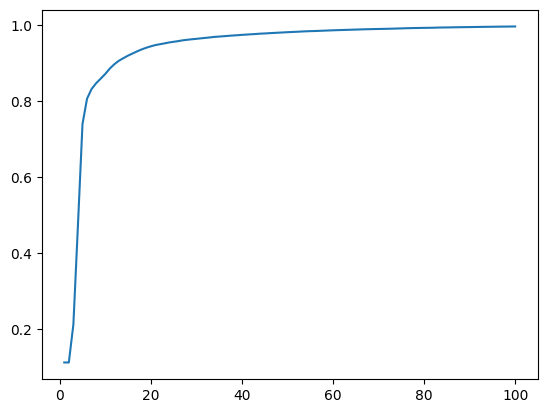

In [7]:
# Run the model
x_train, y_train, x_test, y_test = load_mnist()
model = VanillaNeuralNetwork(layer_sizes=[784, 128, 64, 10], activation='relu', learning_rate=0.01, optimizer=None)
acc_array=train(model, x_train, y_train, epochs=100, batch_size=64)

plt.plot(np.array(range(1,len(acc_array)+1)), acc_array)
plt.show()

Epoch 1/10, Accuracy: 0.9600
Epoch 2/10, Accuracy: 0.9715
Epoch 3/10, Accuracy: 0.9825
Epoch 4/10, Accuracy: 0.9874
Epoch 5/10, Accuracy: 0.9900
Epoch 6/10, Accuracy: 0.9908
Epoch 7/10, Accuracy: 0.9917
Epoch 8/10, Accuracy: 0.9919
Epoch 9/10, Accuracy: 0.9913
Epoch 10/10, Accuracy: 0.9941


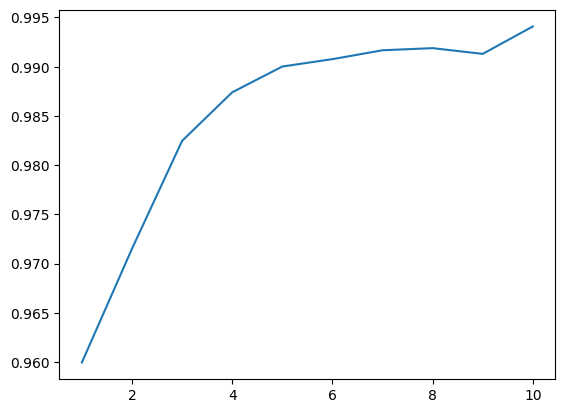

In [6]:
# Run the model
x_train, y_train, x_test, y_test = load_mnist()
model = VanillaNeuralNetwork(layer_sizes=[784, 128, 64, 10], activation='relu', learning_rate=0.01, optimizer='Adam')
acc_array = train(model, x_train, y_train, epochs=10, batch_size=64)

plt.plot(np.array(range(1,len(acc_array)+1)), acc_array)
plt.show()

Here again, we can see the power of using Adam. We can get perfect accuracy in less than 10 epochs and even the 1st epoch accuracy with Adam is on a high level that with the absence of it, the same performance can be reached in 30 epochs.